In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kornia-loftr/outdoor_ds.ckpt
/kaggle/input/kornia-loftr/outdoor_ot.ckpt
/kaggle/input/kornia-loftr/loftr_outdoor.ckpt
/kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
/kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
/kaggle/input/image-matching-challenge-2022/sample_submission.csv
/kaggle/input/image-matching-challenge-2022/test.csv
/kaggle/input/image-matching-challenge-2022/train/LICENSE.txt
/kaggle/input/image-matching-challenge-2022/train/scaling_factors.csv
/kaggle/input/image-matching-challenge-2022/train/british_museum/pair_covisibility.csv
/kaggle/input/image-matching-challenge-2022/train/british_museum/calibration.csv
/kaggle/input/image-matching-challenge-2022/train/british_museum/images/21464353_8770120507.jpg
/kaggle/input/image-matching-challenge-2022/train/british_museum/images/66393650_5300086486.jpg
/kaggle/input/image-matching-challenge-2022/train/british_museum/images/95405900_917617676.jpg
/kaggle/input/image-matching-challenge

# LoFTR Model

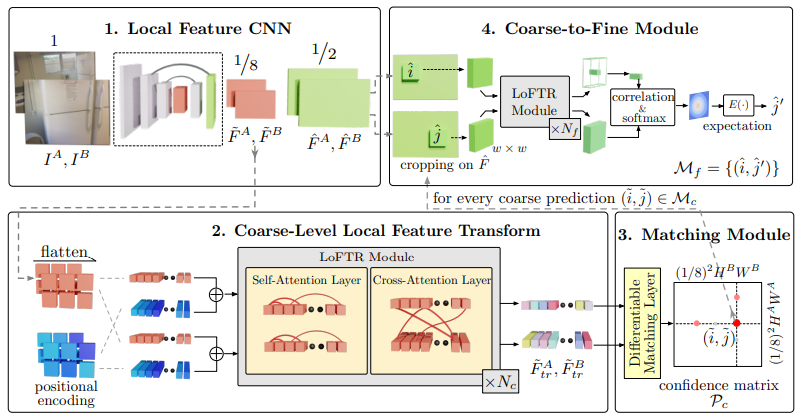

1. **Local Feature Extraction**: LoFTR first extracts local features from the input images using a convolutional neural network (CNN). The local features capture the appearance and geometric information of keypoints in the images.

2. **Transformer-based Matching**: Instead of using traditional feature matching algorithms like SIFT or ORB, LoFTR employs a Transformer-based architecture to perform dense feature matching between the local features of the two input images. The Transformer module captures the contextual information and long-range dependencies between the local features, leading to more accurate matching.

3. **Coarse-to-Fine Matching**: LoFTR uses a coarse-to-fine matching strategy, where it first performs a coarse-level matching to find the initial correspondences, and then refines the matches at a finer level.

4. **End-to-End Training**: LoFTR is trained end-to-end, optimizing a combination of losses that encourage accurate feature matching and geometric consistency between the matched features.

In [2]:
!pip install kornia


In [3]:
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

Processing /kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing installation: kornia 0.7.2
    Uninstalling kornia-0.7.2:
      Successfully uninstalled kornia-0.7.2
Processing /kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl


In [4]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
import matplotlib.pyplot as plt
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF
import gc

In [5]:
device = torch.device('cuda')

print(device)

cuda


In [6]:

matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(torch.load("../input/kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

In [7]:
def load_torch_image(fname, device):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)


def FlattenMatrix(M, num_digits=8):
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])

In [8]:
src = '/kaggle/input/image-matching-challenge-2022/'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]

In [9]:
test_samples

[['googleurban;1cf87530;a5a9975574c94ff9a285f58c39b53d2c-0143f47ee9e54243a1b8454f3e91621a',
  '1cf87530',
  'a5a9975574c94ff9a285f58c39b53d2c',
  '0143f47ee9e54243a1b8454f3e91621a'],
 ['googleurban;6ceaefff;39563e58b2b7411da3f06427c9ee4239-0303b05ca0cb46959eac430e4b2472ca',
  '6ceaefff',
  '39563e58b2b7411da3f06427c9ee4239',
  '0303b05ca0cb46959eac430e4b2472ca'],
 ['googleurban;d91db836;81dd07fb7b9a4e01996cee637f91ca1a-0006b1337a0347f49b4e651c035dfa0e',
  'd91db836',
  '81dd07fb7b9a4e01996cee637f91ca1a',
  '0006b1337a0347f49b4e651c035dfa0e']]

In [10]:
features_dict = {}

import time 

for i, rows in enumerate(test_samples):
    sample_id, batch_id, image_01_id, image_02_id = rows 
    
    start = time.time()
    
    img_1 = load_torch_image(f'{src}/test_images/{batch_id}/{image_01_id}.png', device)
    img_2 = load_torch_image(f'{src}/test_images/{batch_id}/{image_02_id}.png', device)
    
#     print('shape of img_1', img_1.shape)
#     print('shape of img_2', img_2.shape)
    
    input_dict = {'image0': K.color.rgb_to_grayscale(img_1), 'image1': K.color.rgb_to_grayscale(img_2)}
    
    with torch.no_grad():
        correspondences = matcher(input_dict)
        
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    
    if len(mkpts0) > 7:  # fundamental matrix required 7 degree of freedoms 
        # Estimate the fundamental matrix between two sets of matched keypoints
        F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.1845, 0.999999, 220000)
        inliers = inliers > 0
        
        assert F.shape == (3, 3), 'Malformed F?'
        features_dict[sample_id] = F
    else: 
        features_dict[sample_id] = np.zeros((3, 3))
        continue
    
    gc.collect()
    end = time.time()
    
#     if i < 3:
#         print('Running Time: ', end - start, ' s')
        
          
with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in features_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# LoFTR Tutorial

In [11]:
# test_img_1 = load_torch_image('/kaggle/input/image-matching-challenge-2022/test_images/1cf87530/0143f47ee9e54243a1b8454f3e91621a.png', device)
# test_img_2 = load_torch_image('/kaggle/input/image-matching-challenge-2022/test_images/1cf87530/a5a9975574c94ff9a285f58c39b53d2c.png', device)

In [12]:
# # LofTR works on grayscale images only
# input1_dict = {'image0': K.color.rgb_to_grayscale(test_img_1), 'image1': K.color.rgb_to_grayscale(test_img_2)}

In [13]:
# with torch.inference_mode():
#     correspondences = matcher(input1_dict)

In [14]:
# for k, v in correspondences.items():
#     print(k)

Now let’s clean-up the correspondences with modern RANSAC and estimate fundamental matrix between two images

In [15]:
# mkpts0 = correspondences["keypoints0"].cpu().numpy()
# mkpts1 = correspondences["keypoints1"].cpu().numpy()
# Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
# inliers = inliers > 0

Finally, let’s draw the matches with a function from kornia_moons. The correct matches are in green and imprecise matches - in blue

In [16]:
# draw_LAF_matches(
#     KF.laf_from_center_scale_ori(
#         torch.from_numpy(mkpts0).view(1, -1, 2),
#         torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
#         torch.ones(mkpts0.shape[0]).view(1, -1, 1),
#     ),
#     KF.laf_from_center_scale_ori(
#         torch.from_numpy(mkpts1).view(1, -1, 2),
#         torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
#         torch.ones(mkpts1.shape[0]).view(1, -1, 1),
#     ),
#     torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
#     K.tensor_to_image(test_img_1),
#     K.tensor_to_image(test_img_2),
#     inliers,
#     draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
# )